In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
def load_npy(filename):
    return np.load(filename)

In [3]:
dir_path = 'timeseries/'
len_threshold = 1280

In [4]:
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0]) # track_id
    y.append(split[1][:-4]) # genre
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold-len(ts)) # fill with last observation
        ts = np.append(ts, pad) 

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

In [5]:
!pip install sktime==0.25.0

In [6]:
from sktime.transformations.panel.dictionary_based import PAA

In [7]:
def approximate(ts, approx):
    return approx.fit_transform(ts)


In [8]:
ts

array([1760.40333559, 1669.68354612, 1690.64028044, ..., 2342.71927807,
       3021.21525668, 3253.65964701])

In [9]:
paa = PAA(num_intervals=128) # Piecewise Aggregate Approximation w. 100 intervals

In [10]:
X_paa = np.array([[approximate(ts[0], paa)[:,0]] for ts in X])
X_paa.shape


(10000, 1, 128)

In [11]:
y = LabelEncoder().fit_transform(y)

In [12]:
X_train_paa, X_test_paa, y_train, y_test  = train_test_split (
 X_paa, y, test_size=0.2, random_state=42,
stratify=y )
X_train_paa.shape, X_test_paa.shape, y_train.shape, y_test.shape

((8000, 1, 128), (2000, 1, 128), (8000,), (2000,))

In [13]:
X_train = X_train_paa[:800]
y_train = y_train[:800]

X_test = X_test_paa[:200]
y_test = y_test[:200]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 1, 128) (200, 1, 128) (800,) (200,)


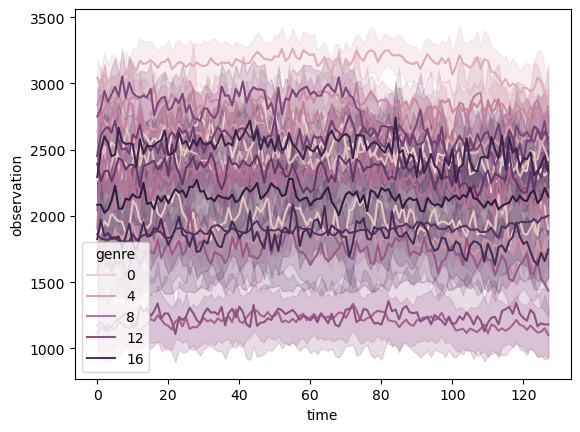

In [14]:
df = pd.DataFrame(np.squeeze(X_train))
df["genre"] = y_train
df_melt = df.melt(value_name="observation", var_name="time", id_vars="genre")
sns.lineplot(df_melt, x="time", y="observation", estimator="mean", hue="genre")
plt.show()

In [15]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

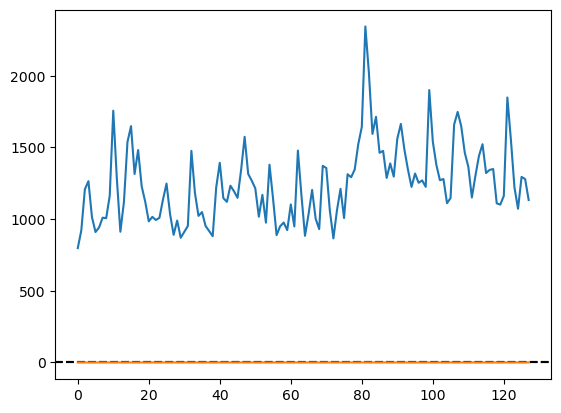

In [16]:
# check that the means and std of each series are 0 and 1
X_train_scaled.min(axis=(1, 2)), X_train_scaled.max(axis=(1, 2))
plt.plot(X_train[1].ravel())
plt.axhline(0, color="black", linestyle="--")
plt.axhline(1, color="black", linestyle="--")
plt.plot(X_train_scaled[0].ravel())

In [17]:
from sklearn.metrics import classification_report
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [18]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=20, distance="dtw")

In [19]:
%%time
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         7
           3       0.08      0.11      0.09         9
           4       0.14      0.10      0.12        10
           5       0.18      0.33      0.23         9
           6       0.08      0.20      0.11        15
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        10
           9       0.12      0.12      0.12         8
          10       0.31      0.31      0.31        13
          11       0.00      0.00      0.00        11
          12       0.16      0.25      0.19        12
          13       0.00      0.00      0.00        11
          14       0.17      0.18      0.17        11
          15       0.07      0.11      0.09         9
          16       0.00      0.00      0.00        10
          17       0.22    

/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elvislleshi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Shapelet transform

In [20]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Përzgjedhja e një pjesë të vogël të të dhënave
X_train_small = X_train[:100]
X_test_small = X_test[:50]
y_train_small = y_train[:100]
y_test_small = y_test[:50]

# Trajnimi i modelit
st.fit(X_train_small, y_train_small)

# Parashikimi dhe vlerësimi
y_pred_small = st.predict(X_test_small)
print(classification_report(y_test_small, y_pred_small))


NameError: name 'st' is not defined

In [22]:
X_train=X_train_small
X_test=X_test_small
Y_test=y_test_small
Y_train=y_train_small

In [23]:
st = ShapeletTransformClassifier()

In [ ]:
¶

In [24]:
%%time
st.fit(X_train_scaled, y_train)
y_pred = st.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         7
           3       0.29      0.56      0.38         9
           4       0.00      0.00      0.00        10
           5       0.20      0.11      0.14         9
           6       0.13      0.13      0.13        15
           7       0.20      0.08      0.12        12
           8       0.20      0.20      0.20        10
           9       0.00      0.00      0.00         8
          10       0.24      0.31      0.27        13
          11       0.00      0.00      0.00        11
          12       0.08      0.17      0.11        12
          13       0.36      0.36      0.36        11
          14       0.10      0.09      0.10        11
          15       0.10      0.44      0.16         9
          16       0.67      0.20      0.31        10
          17       0.12    

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform

In [26]:
rst = RandomShapeletTransform(n_shapelet_samples=1000, max_shapelets=None, min_shapelet_length=3, max_shapelet_length=None, n_jobs=-1) #n_jobs -1 uses all processors

In [27]:
%%time
rst.fit(X_train_scaled, y_train)

CPU times: user 26.7 s, sys: 382 ms, total: 27.1 s
Wall time: 26.9 s


RandomShapeletTransform(n_jobs=-1, n_shapelet_samples=1000)

In [28]:
%%time
shapelets_distances_train = rst.transform(X_train_scaled)
shapelets_distances_test = rst.transform(X_test_scaled)

CPU times: user 17.7 s, sys: 2.22 s, total: 19.9 s
Wall time: 18.7 s


In [29]:
clf = DecisionTreeClassifier()
clf = clf.fit(shapelets_distances_train, y_train)
y_pred = clf.predict(shapelets_distances_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.12      0.10         8
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         9
           4       0.15      0.20      0.17        10
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        12
           8       0.11      0.10      0.11        10
           9       0.08      0.12      0.10         8
          10       0.18      0.23      0.20        13
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00        12
          13       0.50      0.55      0.52        11
          14       0.13      0.18      0.15        11
          15       0.12      0.11      0.12         9
          16       0.22      0.20      0.21        10
          17       0.00    

In [30]:
# Each item in the list is a tuple containing the following 7 items:
# (shapelet information gain, shapelet length, start position the shapelet was extracted from,
# shapelet dimension, index of the instance the shapelet was extracted from in fit,
# class value of the shapelet, The z-normalised shapelet array)
shapelets = rst.shapelets
shapelets[0]

(0.079079924414,
 72,
 1,
 0,
 351,
 8,
 array([-0.97734896,  0.03581031, -0.51504028, -0.11525398, -0.83597063,
        -0.40451632, -0.61428622, -0.68255314, -0.9025382 , -0.59264925,
        -0.51393839, -0.49195376, -0.69347928, -0.66932602, -0.24268991,
        -0.29848849, -0.282368  , -0.21129973,  0.1068145 ,  0.05799974,
        -0.01784814, -0.4846178 , -0.01498501, -0.32288397, -0.1908401 ,
        -0.57267116,  1.42575718, -0.41927692,  1.34888348, -1.11392108,
         1.86429724, -0.72003585,  1.77363741, -1.11747847,  1.7374107 ,
        -0.74638779,  1.61774013, -1.2460274 ,  1.71705969, -0.77086948,
         1.40522748, -0.71903609,  1.35103983, -0.25241475,  1.01097491,
        -0.66706712,  0.58229474,  0.31213978,  0.29832818,  0.18656613,
        -0.14827071,  0.80569018, -0.3335167 ,  0.56398416, -0.88487951,
         1.05900917, -0.81283233,  1.43024292, -1.2753948 ,  1.29338632,
        -1.13348248,  1.5087886 , -1.94693696,  1.7905423 , -1.31923243,
         1.

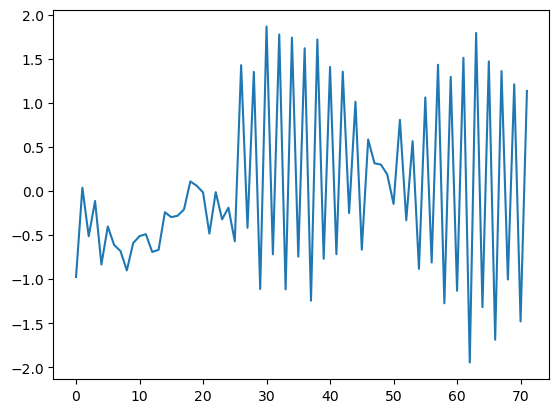

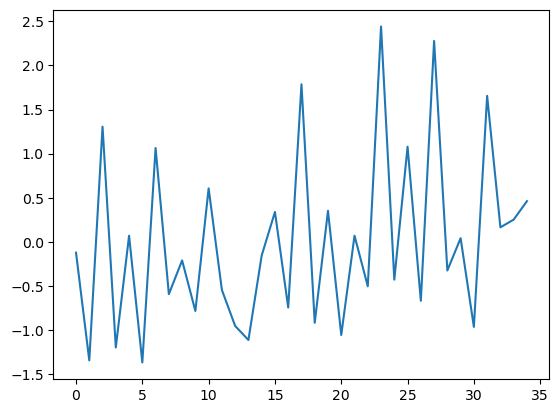

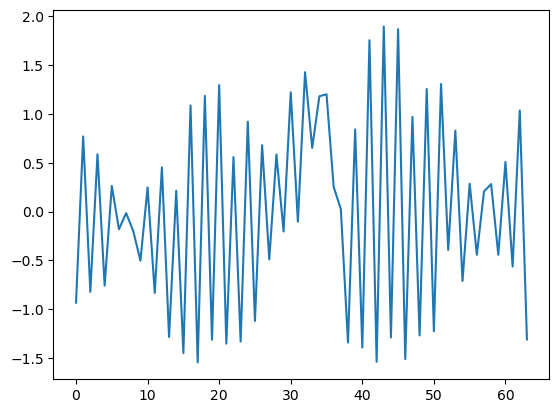

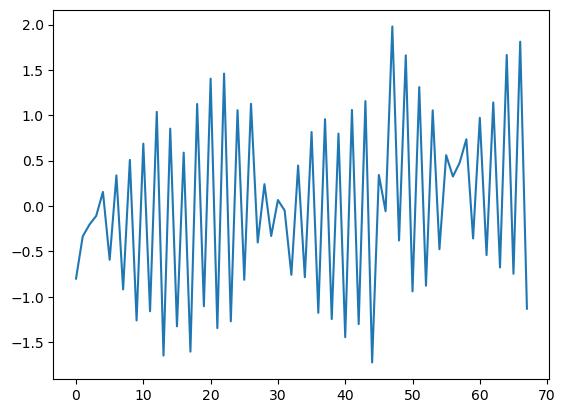

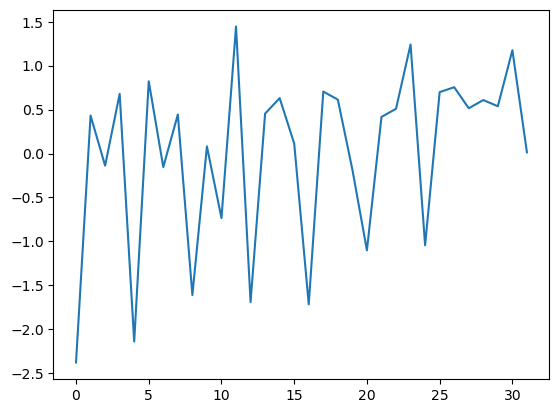

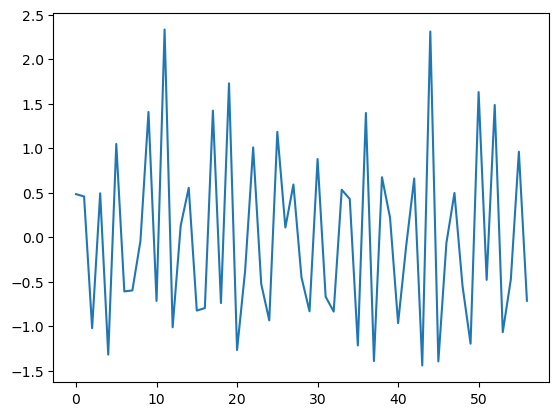

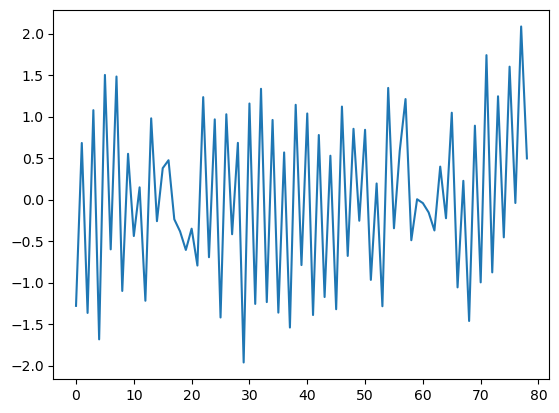

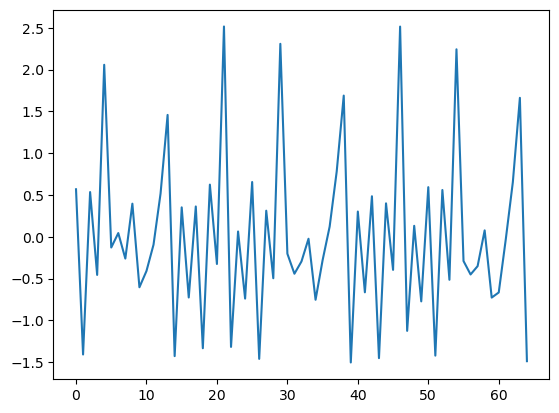

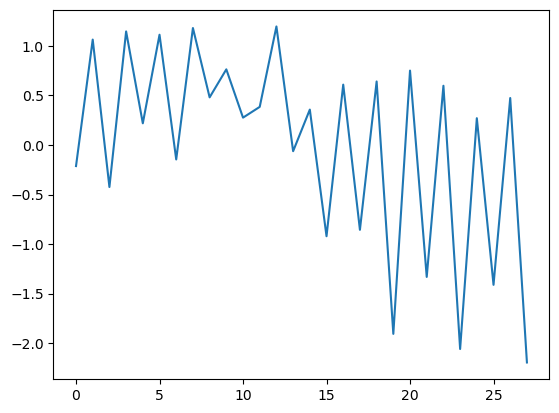

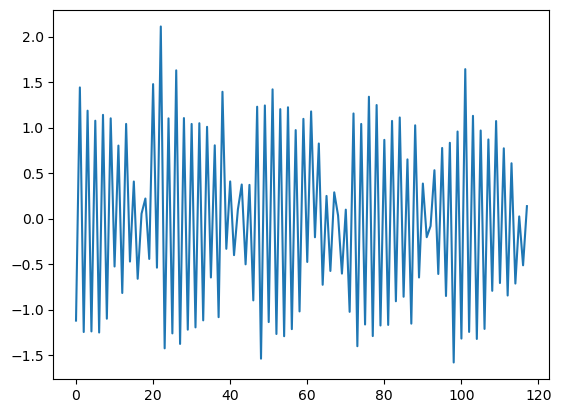

In [31]:
# plotting the z-normalized shapelet arrays
for i in range(10):
  plt.plot(shapelets[i][6])
  plt.show()

In [ ]:
sh_id = 416
start_position = shapelets[sh_id][2]
instance_index = shapelets[sh_id][4]
z_norm_shapelet = shapelets[sh_id][6]
end_position = start_position + len(z_norm_shapelet)

In [ ]:
plt.plot(X_train_scaled[instance_index].ravel(), label='time-series')
plt.plot(np.arange(start_position, end_position), X_train_scaled[instance_index].ravel()[start_position:end_position], linewidth=2, label='shapelet')
plt.plot(np.arange(start_position, end_position), z_norm_shapelet, linewidth=2, label='z-norm shapelet')
plt.axvline(start_position, color='k', linestyle='--', alpha=0.4)
plt.title("The aligned extracted shapelet")
plt.legend()
plt.show()

In [ ]:
# # brute-force approach (works exactly as the RandomShapletTransform - parameters are different)
# from sktime.transformations.panel.shapelet_transform import ShapeletTransform
# st = ShapeletTransform(min_shapelet_length=3, max_shapelet_length=6, max_shapelets_to_store_per_class=5)

# Feature-based classification

In [ ]:

from sktime.pipeline import make_pipeline
from sktime.transformations.series.summarize import SummaryTransformer
from sklearn.linear_model import LogisticRegressionCV
from sktime.pipeline import sklearn_to_sktime


In [ ]:
pipe = make_pipeline(SummaryTransformer(), sklearn_to_sktime(LogisticRegressionCV()))

In [ ]:
%%time
pipe.fit(X_train_scaled, y_train)
y_pred = pipe.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

In [ ]:
f

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [ ]:
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

In [ ]:
mask = np.isin(y_train, [1, 3])
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))
# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {20: 1}
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=Adam(lr=0.01),
                            max_iter=250,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train, y_train)

In [ ]:
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax

# Normalization

In [ ]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled.min(axis=(1, 2)), X_train_scaled.max(axis=(1, 2))
plt.plot(X_train[5].ravel())
plt.axhline(0, color="black", linestyle="--")
plt.axhline(1, color="black", linestyle="--")
plt.plot(X_train_scaled[5].ravel())

# Classification

In [ ]:
pip install keras


In [ ]:
pip install tensorflow

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train_small = y_train[:100]
y_test_small = y_test[:50]

In [ ]:
y_train_small.shape

In [ ]:
import tensorflow as tf

In [ ]:
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

In [ ]:
%%time
cnn.fit(X_train_scaled, y_train_small)
cnn.score(X_test_scaled, y_test_small)

In [ ]:
sns.lineplot(cnn.history.history["loss"], label="loss")
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, LeakyReLU
from keras.layers import Activation, Conv1D, BatchNormalization
from keras.callbacks import EarlyStopping
import keras


In [ ]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(
        Conv1D(
            filters=16, kernel_size=8, activation="relu", input_shape=(n_timesteps, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model

In [ ]:
X_train_cnn = np.swapaxes(X_train_scaled, 1, 2)
X_test_cnn = np.swapaxes(X_test_scaled, 1, 2)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

In [ ]:
cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
callbacks = [es]

In [ ]:
%%time
cnn.fit(
    X_train_cnn,
    y_train,
    epochs=10,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)

In [ ]:
summary = pd.DataFrame(cnn.history.history)
summary

In [ ]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow import keras
# Krijoni modelin CNN
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))  # Për regresion, përdorni aktivacionin linear

# Kompilojeni modelin
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Trajtoni modelin në të dhënat e trajnimit
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Testoni modelin në të dhënat e testimi
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


In [ ]:
%%time
cnn.fit(X_train_scaled, y_train)
cnn.score(X_test_scaled, y_test)

In [ ]:
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

In [ ]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict


In [ ]:
# plot the audio wave
plt.figure(figsize=(20,5))

for ts in y_train[:10]:
  plt.plot(ts)

plt.show()

In [ ]:
!pip install tslearn

ValueError: Found input variables with inconsistent numbers of samples: [100, 800]